In [80]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as tt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn

In [2]:
stats = ((0.5074,0.4867,0.4411),(0.2011,0.1987,0.2025))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [3]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

Files already downloaded and verified


In [4]:
for image, label in train_data:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([3, 32, 32])
Image tensor:  tensor([[[ 2.4495,  2.4495,  2.4495,  ..., -0.1636,  0.7140,  1.1625],
         [ 2.4495,  2.4495,  2.4495,  ..., -0.1831,  0.3825,  0.7335],
         [ 2.4495,  2.4495,  2.4495,  ..., -0.0660,  0.2850,  0.5385],
         ...,
         [-0.5536, -0.8656, -1.1191,  ...,  0.1680, -0.4756, -1.8601],
         [-0.0660, -0.5926, -0.7096,  ...,  0.2265, -0.6316, -2.0941],
         [ 0.2070,  0.0900,  0.2070,  ..., -1.0411, -1.2556, -1.9381]],

        [[ 2.5833,  2.5833,  2.5833,  ...,  0.1755,  1.0636,  1.4781],
         [ 2.5833,  2.5833,  2.5833,  ...,  0.1360,  0.7478,  1.1228],
         [ 2.5833,  2.5833,  2.5833,  ...,  0.1755,  0.5505,  0.7873],
         ...,
         [ 0.1952, -0.1403, -0.3969,  ...,  0.9649,  0.1755, -1.7389],
         [ 0.7084,  0.2150,  0.0965,  ...,  0.7281, -0.2390, -2.1336],
         [ 1.0833,  0.9649,  1.0044,  ..., -0.9297, -1.2258, -2.1139]],

        [[ 2.7600,  2.7600,  2.7600,  ..., -0.4934,  0.3393,  1

In [5]:
train_classes_items = dict()

for train_item in train_data:
    label = train_data.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items

{'cattle': 500,
 'dinosaur': 500,
 'apple': 500,
 'boy': 500,
 'aquarium_fish': 500,
 'telephone': 500,
 'train': 500,
 'cup': 500,
 'cloud': 500,
 'elephant': 500,
 'keyboard': 500,
 'willow_tree': 500,
 'sunflower': 500,
 'castle': 500,
 'sea': 500,
 'bicycle': 500,
 'wolf': 500,
 'squirrel': 500,
 'shrew': 500,
 'pine_tree': 500,
 'rose': 500,
 'television': 500,
 'table': 500,
 'possum': 500,
 'oak_tree': 500,
 'leopard': 500,
 'maple_tree': 500,
 'rabbit': 500,
 'chimpanzee': 500,
 'clock': 500,
 'streetcar': 500,
 'cockroach': 500,
 'snake': 500,
 'lobster': 500,
 'mountain': 500,
 'palm_tree': 500,
 'skyscraper': 500,
 'tractor': 500,
 'shark': 500,
 'butterfly': 500,
 'bottle': 500,
 'bee': 500,
 'chair': 500,
 'woman': 500,
 'hamster': 500,
 'otter': 500,
 'seal': 500,
 'lion': 500,
 'mushroom': 500,
 'girl': 500,
 'sweet_pepper': 500,
 'forest': 500,
 'crocodile': 500,
 'orange': 500,
 'tulip': 500,
 'mouse': 500,
 'camel': 500,
 'caterpillar': 500,
 'man': 500,
 'skunk': 500

In [6]:
BATCH_SIZE = 128
train_dl = DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True)
test_dl = DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


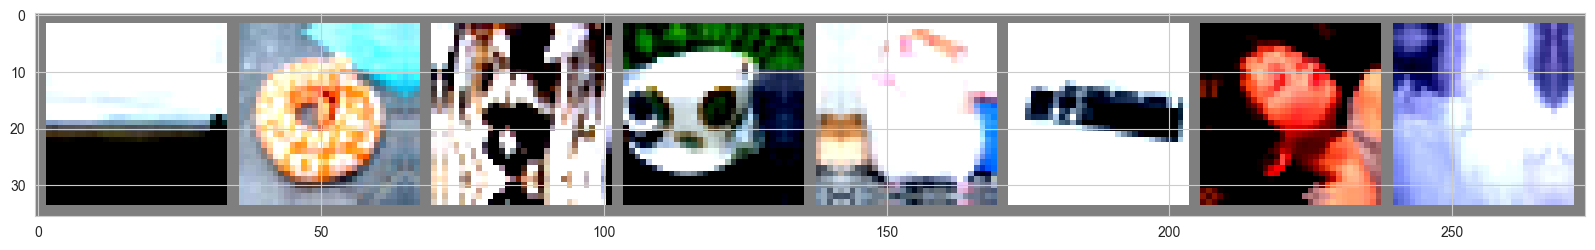

plain               snake               raccoon             cup                 hamster             keyboard            boy                 cloud               


In [7]:
train_8_samples = DataLoader(train_data, 8, num_workers=4, pin_memory=True, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_8_samples)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(''.join(f'{train_data.classes[labels[j]]:20s}' for j in range(8)))

In [8]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)

In [9]:
device = get_device()
print(device)

train_dl = ToDeviceLoader(train_dl, device)
test_dl = ToDeviceLoader(test_dl, device)

cuda


In [10]:
def accuracy(predicted, actual):
    _, predictions = torch.max(predicted, dim=1)
    return torch.tensor(torch.sum(predictions==actual).item()/len(predictions))

In [11]:
class BaseModel(nn.Module):
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {"val_loss":loss.detach(),"val_acc":acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [loss["val_loss"] for loss in outputs]
        loss = torch.stack(batch_losses).mean()
        batch_accuracy = [accuracy["val_acc"] for accuracy in outputs]
        acc = torch.stack(batch_accuracy).mean()
        return {"val_loss":loss.item(),"val_acc":acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
def conv_shortcut(in_channel, out_channel, stride):
    layers = [nn.Conv2d(in_channel, out_channel, kernel_size=(1,1), stride=(stride, stride)),
             nn.BatchNorm2d(out_channel)]
    return nn.Sequential(*layers)

def block(in_channel, out_channel, k_size,stride, conv=False):
    layers = None
    
    first_layers = [nn.Conv2d(in_channel,out_channel[0], kernel_size=(1,1),stride=(1,1)),
                    nn.BatchNorm2d(out_channel[0]),
                    nn.ReLU(inplace=True)]
    if conv:
        first_layers[0].stride=(stride,stride)
    
    second_layers = [nn.Conv2d(out_channel[0], out_channel[1], kernel_size=(k_size, k_size), stride=(1,1), padding=1),
                    nn.BatchNorm2d(out_channel[1])]

    layers = first_layers + second_layers
    
    return nn.Sequential(*layers)
    

class ResNet(BaseModel):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.stg1 = nn.Sequential(
                                   nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(3),
                                             stride=(1), padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size=3, stride=2))
        
        ##stage 2
        self.convShortcut2 = conv_shortcut(64,256,1)
        
        self.conv2 = block(64,[64,256],3,1,conv=True)
        self.ident2 = block(256,[64,256],3,1)

        
        ##stage 3
        self.convShortcut3 = conv_shortcut(256,512,2)
        
        self.conv3 = block(256,[128,512],3,2,conv=True)
        self.ident3 = block(512,[128,512],3,2)

        
        ##stage 4
        self.convShortcut4 = conv_shortcut(512,1024,2)
        
        self.conv4 = block(512,[256,1024],3,2,conv=True)
        self.ident4 = block(1024,[256,1024],3,2)
        
        
        ##Classify
        self.classifier = nn.Sequential(
                                       nn.AvgPool2d(kernel_size=(4)),
                                       nn.Flatten(),
                                       nn.Linear(1024, num_classes))
        
    def forward(self,inputs):
        out = self.stg1(inputs)
        
        #stage 2
        out = F.relu(self.conv2(out) + self.convShortcut2(out))
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        out = F.relu(self.ident2(out) + out)
        
        #stage3
        out = F.relu(self.conv3(out) + (self.convShortcut3(out)))
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        out = F.relu(self.ident3(out) + out)
        
        #stage4             
        out = F.relu(self.conv4(out) + (self.convShortcut4(out)))
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        out = F.relu(self.ident4(out) + out)
        
        #Classify
        out = self.classifier(out)#100x1024
        
        return out

In [13]:
model = ResNet(3,100)

In [14]:
model = to_device(model, device)

In [15]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

In [16]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, weight_decay, scheduler, grad_clip=None):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(), max_lr, weight_decay = weight_decay)
    
    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model, test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history

In [17]:
epochs = 100
optimizer = torch.optim.Adam
max_lr = 1e-3
grad_clip = 0.1
weight_decay = 1e-5
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [18]:
%%time
history = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, 
              optimizer=optimizer, max_lr=max_lr, grad_clip=grad_clip,
              weight_decay=weight_decay, scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch [0], last_lr: 0.00004, train_loss: 3.8558, val_loss: 4.4079, val_acc: 0.0566
Epoch [1], last_lr: 0.00005, train_loss: 3.2076, val_loss: 4.0778, val_acc: 0.0955
Epoch [2], last_lr: 0.00006, train_loss: 2.8912, val_loss: 3.8116, val_acc: 0.1295
Epoch [3], last_lr: 0.00008, train_loss: 2.6509, val_loss: 3.3953, val_acc: 0.1927
Epoch [4], last_lr: 0.00010, train_loss: 2.4612, val_loss: 3.0556, val_acc: 0.2309
Epoch [5], last_lr: 0.00013, train_loss: 2.3193, val_loss: 2.9484, val_acc: 0.2646
Epoch [6], last_lr: 0.00016, train_loss: 2.1927, val_loss: 2.6882, val_acc: 0.3005
Epoch [7], last_lr: 0.00020, train_loss: 2.0922, val_loss: 2.6404, val_acc: 0.3259
Epoch [8], last_lr: 0.00024, train_loss: 1.9996, val_loss: 2.6677, val_acc: 0.3252
Epoch [9], last_lr: 0.00028, train_loss: 1.9208, val_loss: 2.3521, val_acc: 0.3875
Epoch [10], last_lr: 0.00032, train_loss: 1.8553, val_loss: 2.5095, val_acc: 0.3534
Epoch [11], last_lr: 0.00037, train_loss: 1.7978, val_loss: 2.2698, val_acc: 0.4064
Ep

In [28]:
def plot_acc(history):
    plt.plot([x["val_acc"] for x in history],"-")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

def plot_loss(history):
    plt.plot([x.get("train_loss") for x in history], "-b")
    plt.plot([x["val_loss"] for x in history],"-r")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train loss","val loss"])
    
def plot_lrs(history):
    plt.plot(np.concatenate([x.get("lrs",[]) for x in history]))
    plt.xlabel("Batch number")
    plt.ylabel("Learning rate")

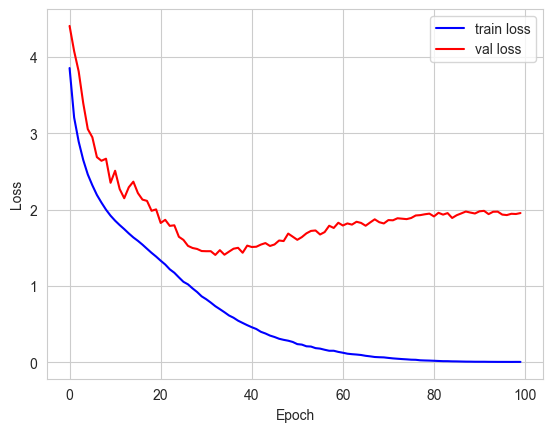

In [29]:
plot_loss(history)

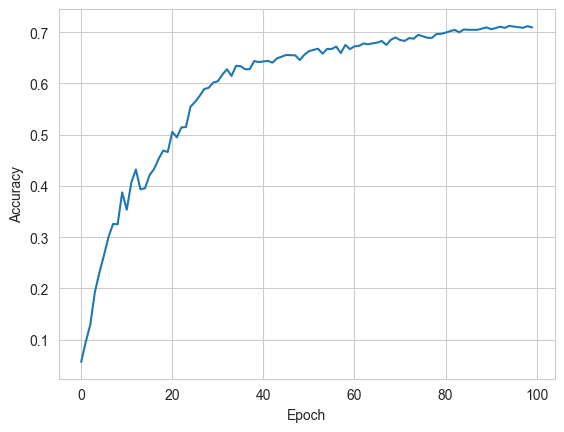

In [30]:
plot_acc(history)

In [32]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return test_data.classes[preds[0].item()]

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap='gray_r',
                          linecolor='k'):

    fmt = '.3f' if normalize else 'd'
    sns.heatmap(cm, fmt=fmt, annot=True, square=True,
                xticklabels=classes, yticklabels=classes,
                cmap=cmap, vmin=0, vmax=0,
                linewidths=0.5, linecolor=linecolor,
                cbar=False)
    sns.despine(left=False, right=False, top=False, bottom=False)
    
    plt.title('Confusion Matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

In [36]:
predicted_class = []
true_class = []

for i in range(len(test_data)):
    img, label = test_data[i]
    true_class.append(test_data.classes[label])
    predicted_class.append(predict_image(img, model))

In [40]:
print(sklearn.metrics.classification_report(true_class, predicted_class, target_names=test_data.classes))

               precision    recall  f1-score   support

        apple       0.93      0.86      0.90       100
aquarium_fish       0.75      0.85      0.80       100
         baby       0.51      0.63      0.56       100
         bear       0.56      0.57      0.56       100
       beaver       0.57      0.56      0.56       100
          bed       0.77      0.73      0.75       100
          bee       0.73      0.78      0.75       100
       beetle       0.80      0.70      0.75       100
      bicycle       0.78      0.84      0.81       100
       bottle       0.79      0.77      0.78       100
         bowl       0.57      0.50      0.53       100
          boy       0.57      0.43      0.49       100
       bridge       0.72      0.83      0.77       100
          bus       0.70      0.62      0.66       100
    butterfly       0.65      0.71      0.68       100
        camel       0.73      0.82      0.77       100
          can       0.78      0.70      0.74       100
       ca

Accuracy:99.6%


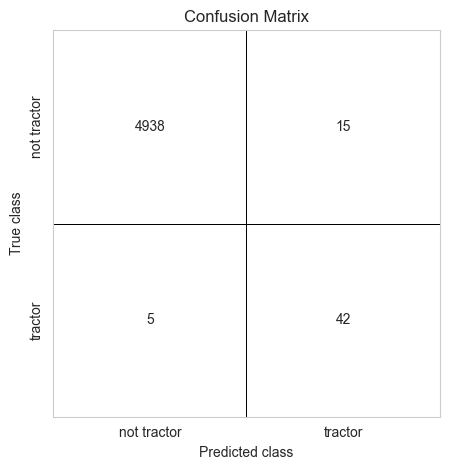

In [70]:
predicted_class = []
true_class = []

for i in range(5000):
    img, label = test_data[i]
    if test_data.classes[label] == 'tractor':
        true_class.append(test_data.classes[label])
    else:
        true_class.append('not tractor')

for i in range(5000):
    img, label = test_data[i]
    
    pred_label = predict_image(img, model)
    if pred_label == 'tractor':
        predicted_class.append(pred_label)
    else:
        predicted_class.append('not tractor')

confusion_mtx = confusion_matrix(true_class, predicted_class)
plot_confusion_matrix(confusion_mtx, classes=["not tractor", "tractor"])

print("Accuracy:" + str(accuracy_score(true_class, predicted_class) * 100) + "%")